In [14]:
import tensorflow as tf
import keras

print("Tensorflow version:", tf.__version__)
print("Keras version:", keras.__version__)

Tensorflow version: 2.13.0
Keras version: 2.13.1


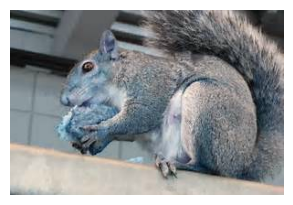

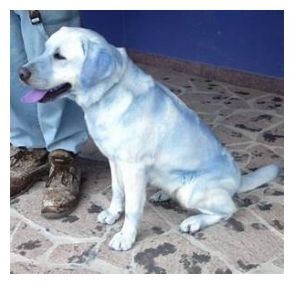

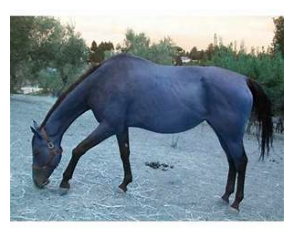

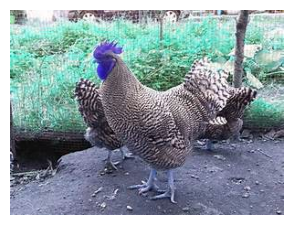

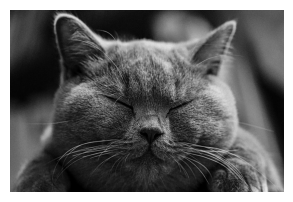

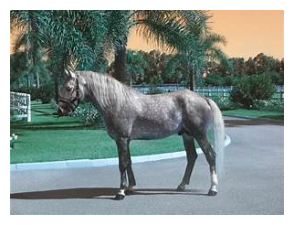

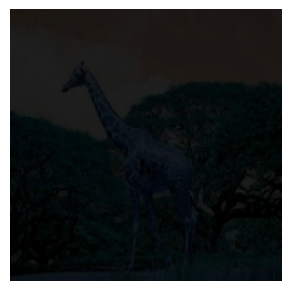

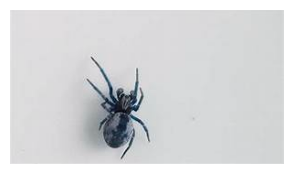

In [15]:
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2

images = glob("../Animal Dataset/train/**/**")
for i in range (8):
    Image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(Image))
    plt.axis('off')

## Preparing Data

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("../Animal Dataset/train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("../Animal Dataset/test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode= "categorical",
                                                    shuffle=True)




Found 5633 images belonging to 20 classes.
Found 22490 images belonging to 20 classes.


In [17]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2D, Activation, MaxPooling2D

def Convolution(input_tensor, filter, kernel_size):
    x = Conv2D(filters=filter, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)

    return x


In [18]:
from tensorflow.keras.layers import Dense, Dropout


def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [19]:
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.models import Model

def model_fer(inputs):
    conv_1 = Convolution(inputs,32,(3,3))
    conv_2 = Convolution(conv_1 ,64,(5,5))
    conv_3 = Convolution(conv_2,128,(3,3))

    flatten = Flatten()(conv_3)

    dense_1 = Dense_f(flatten,256)

    output = Dense(20,activation= "softmax")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])  # Use 'inputs' instead of 'input'
    
    model.compile(loss = ['categorical_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])

    return model

In [20]:
input_shape = (48,48,1)
input_layer = Input(shape=input_shape)
model = model_fer(input_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 32)        0   

## Initiating the model

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint


epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("../Model Weights/model_weights.h5", monitor = 'val_accuracy', save_weights_only= True, mode='auto', verbose=1)
callbacks = [checkpoint]

## Training the model

In [22]:
history = model.fit(
    x = train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_steps//2,
    callbacks=callbacks
)

Epoch 1/5
88/88 [==============================] - ETA: 0s - loss: 2.3632 - accuracy: 0.2701
Epoch 1: saving model to model_weights.h5
88/88 [==============================] - 164s 2s/step - loss: 2.3632 - accuracy: 0.2701 - val_loss: 2.9261 - val_accuracy: 0.2206
Epoch 2/5
88/88 [==============================] - ETA: 0s - loss: 1.9342 - accuracy: 0.3880
Epoch 2: saving model to model_weights.h5
88/88 [==============================] - 86s 988ms/step - loss: 1.9342 - accuracy: 0.3880 - val_loss: 2.0632 - val_accuracy: 0.3563
Epoch 3/5
88/88 [==============================] - ETA: 0s - loss: 1.7012 - accuracy: 0.4529
Epoch 3: saving model to model_weights.h5
88/88 [==============================] - 67s 760ms/step - loss: 1.7012 - accuracy: 0.4529 - val_loss: 1.9058 - val_accuracy: 0.3980
Epoch 4/5
88/88 [==============================] - ETA: 0s - loss: 1.5624 - accuracy: 0.4854
Epoch 4: saving model to model_weights.h5
88/88 [==============================] - 57s 645ms/step - loss: 1.

In [23]:
model.evaluate(validation_generator)

352/352 [==============================] - 42s 119ms/step - loss: 1.7104 - accuracy: 0.4587


[1.7104495763778687, 0.4586927592754364]

## Plotting Accuracy

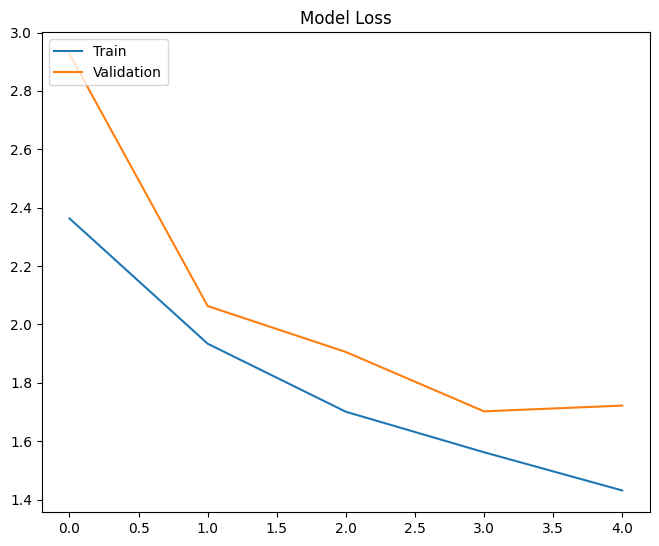

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

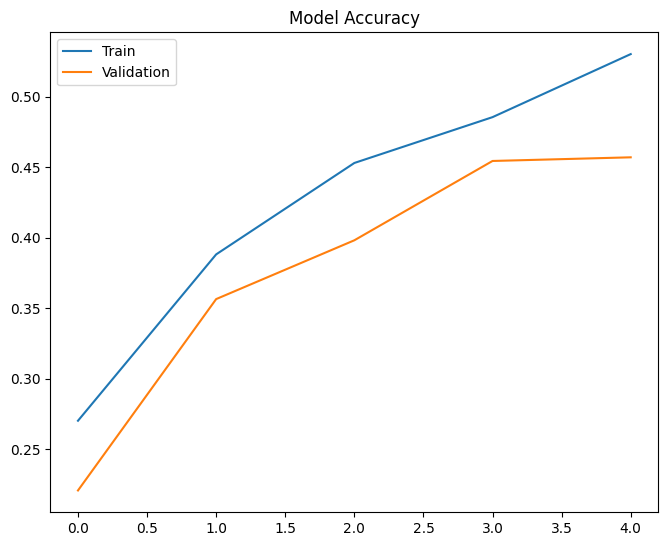

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'],loc = 'upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

In [26]:
model_json = model.to_json()
with open("../Saved model/model_a.json","w") as json_file:
    json_file.write(model_json)